## Part 1: Setup and GPU Configuration

In [21]:
# GPU Setup
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import json
import pickle
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB


## Part 2: Feature Definitions

In [22]:
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max', 'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'nadas', 'flaps'
]

CONTINUOUS_FEATURES = ['edit_distance_avg', 'rare_ases_avg']

ALL_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_avg', 'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps'
]

# Sparse features - apply log1p transform
SPARSE_FEATURES = [
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6', 'imp_wd_spath', 'unique_as_path_max',
    'origin_changes', 'flaps', 'nadas'
]

print(f"Total features: {len(ALL_FEATURES)}, Sparse: {len(SPARSE_FEATURES)}")

Total features: 27, Sparse: 9


In [23]:
# Transform functions
def apply_log_transform(data, feature_names, sparse_features):
    transformed = data.copy()
    indices = []
    for feat in sparse_features:
        if feat in feature_names:
            idx = feature_names.index(feat)
            indices.append(idx)
            transformed[:, idx] = np.log1p(data[:, idx])
    return transformed, indices

def inverse_log_transform(data, feature_names, sparse_features):
    restored = data.copy()
    if len(data.shape) == 3:
        n, s, f = data.shape
        restored = restored.reshape(-1, f)
        reshape = True
    else:
        reshape = False
    
    for feat in sparse_features:
        if feat in feature_names:
            idx = feature_names.index(feat)
            restored[:, idx] = np.expm1(restored[:, idx])
    
    return restored.reshape(n, s, f) if reshape else restored

def post_process_synthetic_data(synthetic_data, feature_names, scaler, sparse_features):
    n, s, f = synthetic_data.shape
    flat = scaler.inverse_transform(synthetic_data.reshape(-1, f))
    flat = inverse_log_transform(flat.reshape(n, s, f), feature_names, sparse_features).reshape(-1, f)
    
    for i, feat in enumerate(feature_names):
        flat[:, i] = np.maximum(flat[:, i], 0)
        if feat in INTEGER_FEATURES:
            flat[:, i] = np.round(flat[:, i])
    
    return flat.reshape(n, s, f)

print("Transform functions defined.")

Transform functions defined.


## Part 3: Configuration

In [24]:
# Paths
DATA_PATH = '/home/smotaali/GAN_Traffic_Producer/RIPE/rrc04_updates_20251116_extracted_discovered.csv'
OUTPUT_DIR = '/home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/'

# Sequence
SEQ_LEN = 30
STRIDE = 1
BATCH_SIZE = 64
EPOCHS = 250

# Learning rates
LR_G = 0.0002
LR_D = 0.0001
BETA1, BETA2 = 0.5, 0.999

# Model capacity (INCREASED)
HIDDEN_DIM = 128
LATENT_DIM = 64
NUM_LAYERS = 3

# Training
LABEL_SMOOTHING = 0.1
NOISE_STD = 0.05
CLIP_VALUE = 1.0

# Loss weights
SPARSE_WEIGHT = 2.0      # Weight for sparse features in MSE
HIST_LOSS_WEIGHT = 0.5   # Histogram loss weight
CORR_LOSS_WEIGHT = 0.3   # Correlation loss weight

# Data split
TEST_SIZE = 0.2
VAL_SIZE = 0.1
N_SYNTHETIC = 2000

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Config: H={HIDDEN_DIM}, L={LATENT_DIM}, Layers={NUM_LAYERS}, Epochs={EPOCHS}")
print(f"Loss weights: Sparse={SPARSE_WEIGHT}, Hist={HIST_LOSS_WEIGHT}, Corr={CORR_LOSS_WEIGHT}")

Config: H=128, L=64, Layers=3, Epochs=250
Loss weights: Sparse=2.0, Hist=0.5, Corr=0.3


## Part 4: Data Loading with Log Transform

In [25]:
print("Loading data...")
df = pd.read_csv(DATA_PATH)
df_normal = df[df['discovered_label'] == 'likely_normal'].copy()
print(f"Normal rows: {len(df_normal):,}")

available_features = [f for f in ALL_FEATURES if f in df_normal.columns]
sparse_indices = [available_features.index(f) for f in SPARSE_FEATURES if f in available_features]
data = df_normal[available_features].fillna(0).values
NUM_FEATURES = len(available_features)

print(f"\nSparse features BEFORE log transform:")
for feat in SPARSE_FEATURES[:4]:
    if feat in available_features:
        idx = available_features.index(feat)
        print(f"  {feat}: range=[{data[:, idx].min():.0f}, {data[:, idx].max():.0f}]")

Loading data...
Normal rows: 67,940

Sparse features BEFORE log transform:
  edit_distance_dict_3: range=[0, 57]
  edit_distance_dict_4: range=[0, 41]
  edit_distance_dict_5: range=[0, 17]
  edit_distance_dict_6: range=[0, 19]


In [26]:
# Apply log transform
data_log, transform_indices = apply_log_transform(data, available_features, SPARSE_FEATURES)

print("Sparse features AFTER log transform:")
for feat in SPARSE_FEATURES[:4]:
    if feat in available_features:
        idx = available_features.index(feat)
        print(f"  {feat}: range=[{data_log[:, idx].min():.2f}, {data_log[:, idx].max():.2f}]")

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data_log)
print(f"\nNormalized range: [{data_norm.min():.4f}, {data_norm.max():.4f}]")

Sparse features AFTER log transform:
  edit_distance_dict_3: range=[0.00, 4.06]
  edit_distance_dict_4: range=[0.00, 3.74]
  edit_distance_dict_5: range=[0.00, 2.89]
  edit_distance_dict_6: range=[0.00, 3.00]

Normalized range: [0.0000, 1.0000]


In [27]:
# Create sequences
sequences = np.array([data_norm[i:i+SEQ_LEN] for i in range(0, len(data_norm)-SEQ_LEN+1, STRIDE)])
X_train_val, X_test = train_test_split(sequences, test_size=TEST_SIZE, random_state=SEED)
X_train, X_val = train_test_split(X_train_val, test_size=VAL_SIZE, random_state=SEED)

print(f"Sequences: {sequences.shape}")
print(f"Train: {X_train.shape[0]:,}, Val: {X_val.shape[0]:,}, Test: {X_test.shape[0]:,}")

train_tensor = torch.FloatTensor(X_train).to(device)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Sequences: (67911, 30, 27)
Train: 48,895, Val: 5,433, Test: 13,583


## Part 5: Loss Functions (Histogram + Correlation)

In [28]:
class DistributionLosses:
    """Additional losses for distribution matching."""
    
    def __init__(self, sparse_indices, sparse_weight=2.0, n_bins=50):
        self.sparse_indices = sparse_indices
        self.sparse_weight = sparse_weight
        self.n_bins = n_bins
    
    def weighted_mse(self, pred, target):
        """MSE with higher weight for sparse features."""
        mse = (pred - target) ** 2
        if self.sparse_indices:
            weights = torch.ones_like(mse)
            for idx in self.sparse_indices:
                weights[:, :, idx] = self.sparse_weight
            mse = mse * weights
        return mse.mean()
    
    def histogram_loss(self, real, fake):
        """
        Soft histogram loss using kernel density estimation.
        Penalizes distribution mismatch per feature.
        """
        # Flatten to (batch * seq_len, features)
        real_flat = real.reshape(-1, real.shape[-1])
        fake_flat = fake.reshape(-1, fake.shape[-1])
        
        loss = 0.0
        n_features = real_flat.shape[1]
        
        for i in range(n_features):
            # Compute histogram-like statistics
            real_col = real_flat[:, i]
            fake_col = fake_flat[:, i]
            
            # Mean and std matching
            mean_diff = (real_col.mean() - fake_col.mean()) ** 2
            std_diff = (real_col.std() - fake_col.std()) ** 2
            
            # Quantile matching (approximates histogram)
            quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
            for q in quantiles:
                real_q = torch.quantile(real_col, q)
                fake_q = torch.quantile(fake_col, q)
                mean_diff += (real_q - fake_q) ** 2
            
            # Higher weight for sparse features
            weight = self.sparse_weight if i in self.sparse_indices else 1.0
            loss += weight * (mean_diff + std_diff)
        
        return loss / n_features
    
    def correlation_loss(self, real, fake):
        """
        Penalizes difference in correlation structure.
        """
        # Flatten
        real_flat = real.reshape(-1, real.shape[-1])
        fake_flat = fake.reshape(-1, fake.shape[-1])
        
        # Compute correlation matrices
        def corrcoef(x):
            # Center
            x_centered = x - x.mean(dim=0, keepdim=True)
            # Covariance
            cov = torch.mm(x_centered.T, x_centered) / (x.shape[0] - 1)
            # Correlation
            std = torch.sqrt(torch.diag(cov) + 1e-8)
            corr = cov / torch.outer(std, std)
            return torch.clamp(corr, -1, 1)
        
        real_corr = corrcoef(real_flat)
        fake_corr = corrcoef(fake_flat)
        
        # Frobenius norm of difference
        corr_diff = torch.mean((real_corr - fake_corr) ** 2)
        
        return corr_diff

# Initialize
dist_losses = DistributionLosses(sparse_indices, SPARSE_WEIGHT)
print("Distribution losses defined (weighted MSE, histogram, correlation).")

Distribution losses defined (weighted MSE, histogram, correlation).


## Part 6: Improved LSTM-GAN

In [29]:
class LSTM_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True,
                           dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        bs, seq, _ = z.shape
        out, _ = self.lstm(z)
        out = out.contiguous().view(-1, out.size(-1))
        out = self.fc(out)
        return out.view(bs, seq, -1)

class LSTM_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                           dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class ImprovedLSTMGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, seq_len, device, dist_losses):
        self.device = device
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.dist_losses = dist_losses
        
        self.G = LSTM_Generator(latent_dim, hidden_dim, input_dim, num_layers).to(device)
        self.D = LSTM_Discriminator(input_dim, hidden_dim, num_layers).to(device)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, label_smoothing=0.1):
        opt_g = optim.Adam(self.G.parameters(), lr=lr_g, betas=(BETA1, BETA2))
        opt_d = optim.Adam(self.D.parameters(), lr=lr_d, betas=(BETA1, BETA2))
        
        sched_g = optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=epochs, eta_min=lr_g/10)
        sched_d = optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=epochs, eta_min=lr_d/10)
        
        history = {'g_loss': [], 'd_loss': []}
        start = time.time()
        
        real_label = 1.0 - label_smoothing
        fake_label = label_smoothing
        
        for epoch in range(epochs):
            g_losses, d_losses = [], []
            
            for batch in train_loader:
                real = batch[0]
                bs = real.size(0)
                
                real_labels = torch.full((bs, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, 1), fake_label).to(self.device)
                
                # Train D
                opt_d.zero_grad()
                real_noisy = torch.clamp(real + NOISE_STD * torch.randn_like(real), 0, 1)
                d_real = self.D(real_noisy)
                loss_real = self.criterion(d_real, real_labels)
                
                z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                fake = self.G(z)
                d_fake = self.D(fake.detach())
                loss_fake = self.criterion(d_fake, fake_labels)
                
                d_loss = loss_real + loss_fake
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), CLIP_VALUE)
                opt_d.step()
                
                # Train G (2x when D is strong)
                n_g = 2 if d_loss.item() < 0.5 else 1
                for _ in range(n_g):
                    opt_g.zero_grad()
                    z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                    fake = self.G(z)
                    d_fake = self.D(fake)
                    
                    # Adversarial loss
                    g_loss = self.criterion(d_fake, real_labels)
                    
                    # Feature matching (weighted MSE)
                    g_loss += self.dist_losses.weighted_mse(fake, real) * 10
                    
                    # Histogram loss
                    g_loss += self.dist_losses.histogram_loss(real, fake) * HIST_LOSS_WEIGHT
                    
                    # Correlation loss
                    g_loss += self.dist_losses.correlation_loss(real, fake) * CORR_LOSS_WEIGHT
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.G.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            sched_g.step()
            sched_d.step()
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            
            if (epoch + 1) % 25 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | G: {history['g_loss'][-1]:.4f}")
        
        print(f"  Time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples):
        self.G.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim).to(self.device)
            return self.G(z).cpu().numpy()

print("Improved LSTM-GAN defined.")

Improved LSTM-GAN defined.


## Part 7: Improved TimeGAN

In [30]:
class TimeGAN_Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True,
                         dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x):
        h, _ = self.rnn(x)
        return torch.sigmoid(self.fc(h))

class TimeGAN_Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True,
                         dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
                                nn.Linear(hidden_dim, output_dim), nn.Sigmoid())
    def forward(self, h):
        r, _ = self.rnn(h)
        return self.fc(r)

class TimeGAN_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(latent_dim, hidden_dim, num_layers, batch_first=True,
                         dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, z):
        e, _ = self.rnn(z)
        return torch.sigmoid(self.fc(e))

class TimeGAN_Supervisor(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, max(1, num_layers-1), batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, h):
        s, _ = self.rnn(h)
        return torch.sigmoid(self.fc(s))

class TimeGAN_Discriminator(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True,
                         dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2), nn.LeakyReLU(0.2),
                                nn.Linear(hidden_dim//2, 1))
    def forward(self, h):
        d, _ = self.rnn(h)
        return self.fc(d)

print("TimeGAN components defined.")

TimeGAN components defined.


In [31]:
class ImprovedTimeGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, device, dist_losses):
        self.device = device
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.dist_losses = dist_losses
        
        self.embedder = TimeGAN_Embedder(input_dim, hidden_dim, num_layers).to(device)
        self.recovery = TimeGAN_Recovery(hidden_dim, input_dim, num_layers).to(device)
        self.generator = TimeGAN_Generator(latent_dim, hidden_dim, num_layers).to(device)
        self.supervisor = TimeGAN_Supervisor(hidden_dim, num_layers).to(device)
        self.discriminator = TimeGAN_Discriminator(hidden_dim, num_layers).to(device)
        self.bce = nn.BCEWithLogitsLoss()
    
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, label_smoothing=0.1):
        opt_e = optim.Adam(list(self.embedder.parameters()) + list(self.recovery.parameters()), lr=lr_g)
        opt_s = optim.Adam(self.supervisor.parameters(), lr=lr_g)
        opt_g = optim.Adam(list(self.generator.parameters()) + list(self.supervisor.parameters()), lr=lr_g)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr_d)
        
        history = {'e_loss': [], 's_loss': [], 'g_loss': [], 'd_loss': []}
        start = time.time()
        
        real_label = 1.0 - label_smoothing
        fake_label = label_smoothing
        
        # Phase 1: Embedding
        print("  Phase 1: Embedding...")
        for epoch in range(epochs // 3):
            e_losses = []
            for batch in train_loader:
                x = batch[0]
                opt_e.zero_grad()
                h = self.embedder(x)
                x_tilde = self.recovery(h)
                loss = self.dist_losses.weighted_mse(x_tilde, x)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.embedder.parameters(), CLIP_VALUE)
                torch.nn.utils.clip_grad_norm_(self.recovery.parameters(), CLIP_VALUE)
                opt_e.step()
                e_losses.append(loss.item())
            history['e_loss'].append(np.mean(e_losses))
            if (epoch + 1) % 20 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | E: {history['e_loss'][-1]:.4f}")
        
        # Phase 2: Supervised
        print("  Phase 2: Supervised...")
        for epoch in range(epochs // 3):
            s_losses = []
            for batch in train_loader:
                x = batch[0]
                opt_s.zero_grad()
                h = self.embedder(x)
                h_s = self.supervisor(h)
                loss = nn.MSELoss()(h[:, 1:, :], h_s[:, :-1, :])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.supervisor.parameters(), CLIP_VALUE)
                opt_s.step()
                s_losses.append(loss.item())
            history['s_loss'].append(np.mean(s_losses))
            if (epoch + 1) % 20 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | S: {history['s_loss'][-1]:.4f}")
        
        # Phase 3: Joint
        print("  Phase 3: Joint...")
        for epoch in range(epochs // 3):
            g_losses, d_losses = [], []
            for batch in train_loader:
                x = batch[0]
                bs, seq_len, _ = x.shape
                z = torch.randn(bs, seq_len, self.latent_dim).to(self.device)
                
                real_labels = torch.full((bs, seq_len, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, seq_len, 1), fake_label).to(self.device)
                
                # Generator (2x)
                for _ in range(2):
                    opt_g.zero_grad()
                    h = self.embedder(x)
                    h_s = self.supervisor(h)
                    e_hat = self.generator(z)
                    h_hat = self.supervisor(e_hat)
                    x_hat = self.recovery(h_hat)
                    
                    y_fake = self.discriminator(h_hat)
                    g_loss = self.bce(y_fake, real_labels)
                    g_loss += nn.MSELoss()(h[:, 1:, :], h_s[:, :-1, :]) * 10
                    
                    # Distribution losses
                    g_loss += self.dist_losses.weighted_mse(x_hat, x) * 100
                    g_loss += self.dist_losses.histogram_loss(x, x_hat) * HIST_LOSS_WEIGHT
                    g_loss += self.dist_losses.correlation_loss(x, x_hat) * CORR_LOSS_WEIGHT
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.generator.parameters(), CLIP_VALUE)
                    torch.nn.utils.clip_grad_norm_(self.supervisor.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                # Discriminator
                opt_d.zero_grad()
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                y_real = self.discriminator(h)
                y_fake = self.discriminator(h_hat.detach())
                d_loss = self.bce(y_real, real_labels) + self.bce(y_fake, fake_labels)
                
                if d_loss.item() > 0.3:
                    d_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), CLIP_VALUE)
                    opt_d.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            if (epoch + 1) % 20 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | D: {history['d_loss'][-1]:.4f} | G: {history['g_loss'][-1]:.4f}")
        
        print(f"  Time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples, seq_len):
        self.generator.eval()
        self.supervisor.eval()
        self.recovery.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, seq_len, self.latent_dim).to(self.device)
            e_hat = self.generator(z)
            h_hat = self.supervisor(e_hat)
            return self.recovery(h_hat).cpu().numpy()

print("Improved TimeGAN defined.")

Improved TimeGAN defined.


## Part 8: Improved DoppelGANger

In [32]:
class DG_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True,
                           dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
                                nn.Linear(hidden_dim, output_dim), nn.Sigmoid())
    def forward(self, z):
        out, _ = self.lstm(z)
        return self.fc(out)

class DG_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                           bidirectional=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.LeakyReLU(0.2),
                                nn.Dropout(0.4), nn.Linear(hidden_dim, 1))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class ImprovedDoppelGANger:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, seq_len, device, dist_losses):
        self.device = device
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.dist_losses = dist_losses
        
        self.G = DG_Generator(latent_dim, hidden_dim, input_dim, num_layers).to(device)
        self.D = DG_Discriminator(input_dim, hidden_dim, num_layers).to(device)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, label_smoothing=0.1):
        opt_g = optim.Adam(self.G.parameters(), lr=lr_g, betas=(BETA1, BETA2))
        opt_d = optim.Adam(self.D.parameters(), lr=lr_d, betas=(BETA1, BETA2))
        
        sched_g = optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=epochs, eta_min=lr_g/10)
        sched_d = optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=epochs, eta_min=lr_d/10)
        
        history = {'g_loss': [], 'd_loss': []}
        start = time.time()
        
        real_label = 1.0 - label_smoothing
        fake_label = label_smoothing
        
        for epoch in range(epochs):
            g_losses, d_losses = [], []
            
            for batch in train_loader:
                real = batch[0]
                bs = real.size(0)
                
                real_labels = torch.full((bs, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, 1), fake_label).to(self.device)
                
                # Train D
                opt_d.zero_grad()
                d_real = self.D(real)
                loss_real = self.criterion(d_real, real_labels)
                
                z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                fake = self.G(z)
                d_fake = self.D(fake.detach())
                loss_fake = self.criterion(d_fake, fake_labels)
                
                d_loss = loss_real + loss_fake
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), CLIP_VALUE)
                opt_d.step()
                
                # Train G (2x)
                for _ in range(2):
                    opt_g.zero_grad()
                    z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                    fake = self.G(z)
                    d_fake = self.D(fake)
                    
                    g_loss = self.criterion(d_fake, real_labels)
                    g_loss += self.dist_losses.weighted_mse(fake, real) * 10
                    g_loss += self.dist_losses.histogram_loss(real, fake) * HIST_LOSS_WEIGHT
                    g_loss += self.dist_losses.correlation_loss(real, fake) * CORR_LOSS_WEIGHT
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.G.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            sched_g.step()
            sched_d.step()
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            
            if (epoch + 1) % 25 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | G: {history['g_loss'][-1]:.4f}")
        
        print(f"  Time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples):
        self.G.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim).to(self.device)
            return self.G(z).cpu().numpy()

print("Improved DoppelGANger defined.")

Improved DoppelGANger defined.


## Part 9: Training All Models

In [33]:
models = {}
histories = {}
synthetic_raw = {}
synthetic_processed = {}

total_start = time.time()

In [34]:
# Train LSTM-GAN
print("\n" + "="*60)
print("Training Improved LSTM-GAN")
print("="*60)

lstm_gan = ImprovedLSTMGAN(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, SEQ_LEN, device, dist_losses)
histories['LSTM-GAN'] = lstm_gan.train(train_loader, EPOCHS, lr_g=LR_G, lr_d=LR_D, label_smoothing=LABEL_SMOOTHING)
models['LSTM-GAN'] = lstm_gan
synthetic_raw['LSTM-GAN'] = lstm_gan.generate(N_SYNTHETIC)
print(f"Generated: {synthetic_raw['LSTM-GAN'].shape}")


Training Improved LSTM-GAN
  Epoch  25/250 | D: 1.3802 | G: 1.1509
  Epoch  50/250 | D: 1.3831 | G: 1.1602
  Epoch  75/250 | D: 1.3694 | G: 1.1682
  Epoch 100/250 | D: 1.3782 | G: 1.1630
  Epoch 125/250 | D: 1.3665 | G: 1.1809
  Epoch 150/250 | D: 1.3345 | G: 1.2179
  Epoch 175/250 | D: 1.3308 | G: 1.2300
  Epoch 200/250 | D: 1.3309 | G: 1.2320
  Epoch 225/250 | D: 1.3235 | G: 1.2385
  Epoch 250/250 | D: 1.3222 | G: 1.2534
  Time: 376.4 min
Generated: (2000, 30, 27)


In [35]:
# Train TimeGAN
print("\n" + "="*60)
print("Training Improved TimeGAN")
print("="*60)

timegan = ImprovedTimeGAN(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, device, dist_losses)
histories['TimeGAN'] = timegan.train(train_loader, EPOCHS, lr_g=LR_G, lr_d=LR_D, label_smoothing=LABEL_SMOOTHING)
models['TimeGAN'] = timegan
synthetic_raw['TimeGAN'] = timegan.generate(N_SYNTHETIC, SEQ_LEN)
print(f"Generated: {synthetic_raw['TimeGAN'].shape}")


Training Improved TimeGAN
  Phase 1: Embedding...
    Epoch 20/83 | E: 0.0020
    Epoch 40/83 | E: 0.0011
    Epoch 60/83 | E: 0.0009
    Epoch 80/83 | E: 0.0007
  Phase 2: Supervised...
    Epoch 20/83 | S: 0.0048
    Epoch 40/83 | S: 0.0047
    Epoch 60/83 | S: 0.0045
    Epoch 80/83 | S: 0.0041
  Phase 3: Joint...
    Epoch 20/83 | D: 1.2773 | G: 3.5436
    Epoch 40/83 | D: 1.2670 | G: 3.9831
    Epoch 60/83 | D: 1.2916 | G: 3.7819
    Epoch 80/83 | D: 1.2889 | G: 3.9598
  Time: 257.3 min
Generated: (2000, 30, 27)


In [36]:
# Train DoppelGANger
print("\n" + "="*60)
print("Training Improved DoppelGANger")
print("="*60)

doppelganger = ImprovedDoppelGANger(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, SEQ_LEN, device, dist_losses)
histories['DoppelGANger'] = doppelganger.train(train_loader, EPOCHS, lr_g=LR_G, lr_d=LR_D, label_smoothing=LABEL_SMOOTHING)
models['DoppelGANger'] = doppelganger
synthetic_raw['DoppelGANger'] = doppelganger.generate(N_SYNTHETIC)
print(f"Generated: {synthetic_raw['DoppelGANger'].shape}")

print(f"\nTotal training time: {(time.time()-total_start)/60:.1f} min")


Training Improved DoppelGANger
  Epoch  25/250 | D: 1.3964 | G: 1.1390
  Epoch  50/250 | D: 1.3820 | G: 1.1346
  Epoch  75/250 | D: 1.3856 | G: 1.1463
  Epoch 100/250 | D: 1.3924 | G: 1.1531
  Epoch 125/250 | D: 1.3844 | G: 1.1405
  Epoch 150/250 | D: 1.3920 | G: 1.1441
  Epoch 175/250 | D: 1.3813 | G: 1.1563
  Epoch 200/250 | D: 1.3729 | G: 1.1633
  Epoch 225/250 | D: 1.3633 | G: 1.1753
  Epoch 250/250 | D: 1.3672 | G: 1.1705
  Time: 715.7 min
Generated: (2000, 30, 27)

Total training time: 1349.5 min


## Part 10: Post-Processing

In [37]:
print("="*60)
print("POST-PROCESSING: Denormalize -> Inverse Log -> Clip -> Round")
print("="*60)

for name, raw in synthetic_raw.items():
    processed = post_process_synthetic_data(raw, available_features, scaler, SPARSE_FEATURES)
    synthetic_processed[name] = processed
    print(f"{name}: [{raw.min():.3f}, {raw.max():.3f}] -> [{processed.min():.0f}, {processed.max():.0f}]")

POST-PROCESSING: Denormalize -> Inverse Log -> Clip -> Round
LSTM-GAN: [0.000, 0.970] -> [0, 1161]
TimeGAN: [0.000, 0.656] -> [0, 158]
DoppelGANger: [0.000, 0.965] -> [0, 1068]


## Part 11: Evaluation

In [38]:
def calculate_metrics(real_data, syn_data, feature_names, sparse_features):
    real_flat = real_data.reshape(-1, len(feature_names))
    syn_flat = syn_data.reshape(-1, len(feature_names))
    
    metrics = {'per_feature': {}, 'ks_stats': [], 'mae_values': [], 'sparse_ks': [], 'poor_ks': []}
    
    for i, feat in enumerate(feature_names):
        real_col, syn_col = real_flat[:, i], syn_flat[:, i]
        if real_col.std() < 1e-10 or syn_col.std() < 1e-10:
            continue
        
        ks_stat, _ = stats.ks_2samp(real_col, syn_col)
        mae = np.abs(real_col.mean() - syn_col.mean())
        
        if not np.isnan(ks_stat):
            metrics['ks_stats'].append(ks_stat)
            if feat in sparse_features:
                metrics['sparse_ks'].append((feat, ks_stat))
            if ks_stat > 0.2:
                metrics['poor_ks'].append((feat, ks_stat))
        if not np.isnan(mae):
            metrics['mae_values'].append(mae)
        
        metrics['per_feature'][feat] = {'ks': ks_stat, 'mae': mae}
    
    metrics['ks_mean'] = np.mean(metrics['ks_stats']) if metrics['ks_stats'] else np.nan
    metrics['mae_mean'] = np.mean(metrics['mae_values']) if metrics['mae_values'] else np.nan
    metrics['sparse_ks_mean'] = np.mean([x[1] for x in metrics['sparse_ks']]) if metrics['sparse_ks'] else np.nan
    
    real_corr = np.nan_to_num(np.corrcoef(real_flat.T), nan=0)
    syn_corr = np.nan_to_num(np.corrcoef(syn_flat.T), nan=0)
    metrics['corr_error'] = np.mean(np.abs(real_corr - syn_corr))
    
    metrics['overall_score'] = (0.4 * metrics['ks_mean'] + 0.3 * metrics['sparse_ks_mean'] + 
                                0.2 * min(metrics['mae_mean']/100, 1) + 0.1 * metrics['corr_error'])
    
    return metrics

In [39]:
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

X_test_original = post_process_synthetic_data(X_test, available_features, scaler, SPARSE_FEATURES)

all_metrics = {}
for name, syn_data in synthetic_processed.items():
    metrics = calculate_metrics(X_test_original, syn_data, available_features, SPARSE_FEATURES)
    all_metrics[name] = metrics
    
    print(f"\n{name}:")
    print(f"  KS (all):      {metrics['ks_mean']:.4f}")
    print(f"  KS (sparse):   {metrics['sparse_ks_mean']:.4f}")
    print(f"  MAE:           {metrics['mae_mean']:.4f}")
    print(f"  Corr Error:    {metrics['corr_error']:.4f}")
    print(f"  Overall Score: {metrics['overall_score']:.4f}")
    if metrics['poor_ks']:
        print(f"  Poor KS (>0.2): {[f[0] for f in metrics['poor_ks']]}")
    else:
        print(f"  Poor KS (>0.2): None - ALL FEATURES BELOW THRESHOLD!")


EVALUATION RESULTS

LSTM-GAN:
  KS (all):      0.1083
  KS (sparse):   0.0515
  MAE:           1.5309
  Corr Error:    0.0785
  Overall Score: 0.0697
  Poor KS (>0.2): ['withdrawals', 'origin_0', 'edit_distance_dict_1']

TimeGAN:
  KS (all):      0.2963
  KS (sparse):   0.2436
  MAE:           4.8888
  Corr Error:    0.1861
  Overall Score: 0.2200
  Poor KS (>0.2): ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_3', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas']

DoppelGANger:
  KS (all):      0.1007
  KS (sparse):   0.0705
  MAE:           0.7358
  Corr Error:    0.0481
  Overall Score: 0.0677
  Poor KS (>0.2): ['origin_0', 'origin_2']


In [40]:
# Detailed sparse feature analysis
print("\n" + "="*60)
print("SPARSE FEATURE KS STATISTICS (Target: < 0.2)")
print("="*60)

# Original problematic features
ORIGINAL_POOR = ['edit_distance_dict_3', 'imp_wd_spath', 'unique_as_path_max', 'origin_changes']

for name, metrics in all_metrics.items():
    print(f"\n{name}:")
    print("-" * 55)
    for feat, ks in sorted(metrics['sparse_ks'], key=lambda x: x[1], reverse=True):
        status = "✓" if ks < 0.15 else "~" if ks < 0.2 else "✗"
        highlight = " <-- ORIGINAL PROBLEM" if feat in ORIGINAL_POOR else ""
        print(f"  [{status}] {feat:25s}: KS={ks:.4f}{highlight}")


SPARSE FEATURE KS STATISTICS (Target: < 0.2)

LSTM-GAN:
-------------------------------------------------------
  [✓] edit_distance_dict_3     : KS=0.1020 <-- ORIGINAL PROBLEM
  [✓] imp_wd_spath             : KS=0.0895 <-- ORIGINAL PROBLEM
  [✓] flaps                    : KS=0.0695
  [✓] origin_changes           : KS=0.0494 <-- ORIGINAL PROBLEM
  [✓] nadas                    : KS=0.0484
  [✓] unique_as_path_max       : KS=0.0447 <-- ORIGINAL PROBLEM
  [✓] edit_distance_dict_4     : KS=0.0248
  [✓] edit_distance_dict_5     : KS=0.0246
  [✓] edit_distance_dict_6     : KS=0.0105

TimeGAN:
-------------------------------------------------------
  [✗] nadas                    : KS=0.3868
  [✗] imp_wd_spath             : KS=0.3608 <-- ORIGINAL PROBLEM
  [✗] unique_as_path_max       : KS=0.2817 <-- ORIGINAL PROBLEM
  [✗] edit_distance_dict_3     : KS=0.2806 <-- ORIGINAL PROBLEM
  [✗] origin_changes           : KS=0.2021 <-- ORIGINAL PROBLEM
  [~] edit_distance_dict_4     : KS=0.1650
  [~] fl

In [41]:
# Determine best model
best_model = min(all_metrics.keys(), key=lambda k: all_metrics[k]['overall_score'])
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*60}")
print(f"  Overall Score: {all_metrics[best_model]['overall_score']:.4f}")
print(f"  KS (all):      {all_metrics[best_model]['ks_mean']:.4f}")
print(f"  KS (sparse):   {all_metrics[best_model]['sparse_ks_mean']:.4f}")


BEST MODEL: DoppelGANger
  Overall Score: 0.0677
  KS (all):      0.1007
  KS (sparse):   0.0705


## Part 12: Visualization

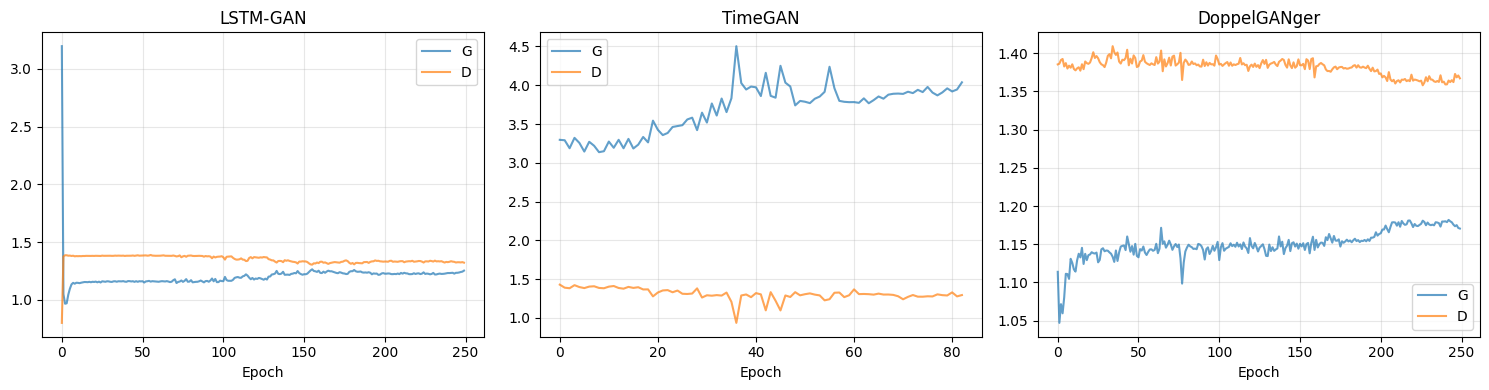

In [42]:
# Training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx]
    if 'g_loss' in hist:
        ax.plot(hist['g_loss'], label='G', alpha=0.7)
    if 'd_loss' in hist:
        ax.plot(hist['d_loss'], label='D', alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

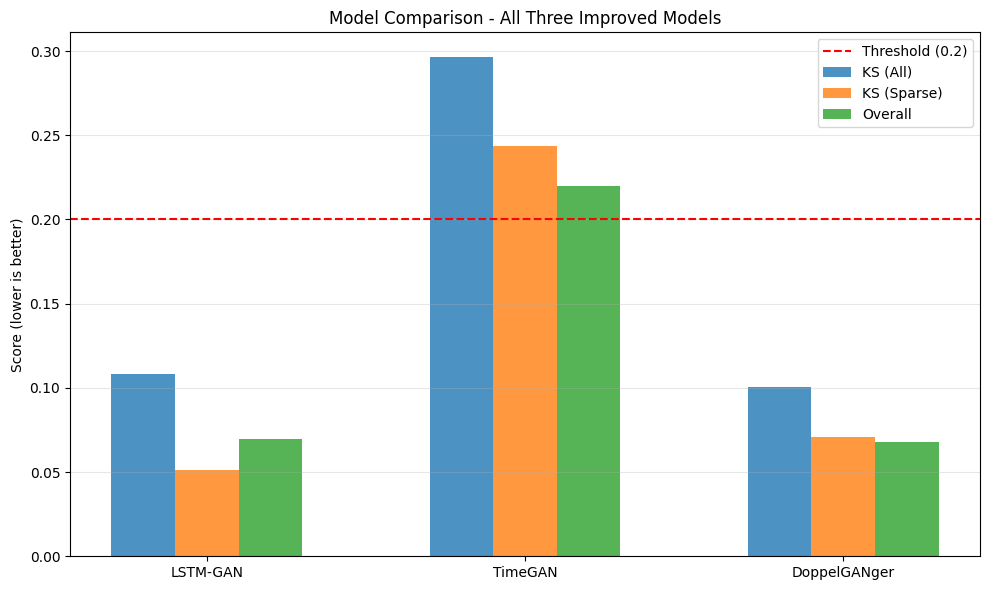

In [43]:
# Model comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))
models_list = list(all_metrics.keys())
x = np.arange(len(models_list))
width = 0.2

ax.bar(x - width, [all_metrics[m]['ks_mean'] for m in models_list], width, label='KS (All)', alpha=0.8)
ax.bar(x, [all_metrics[m]['sparse_ks_mean'] for m in models_list], width, label='KS (Sparse)', alpha=0.8)
ax.bar(x + width, [all_metrics[m]['overall_score'] for m in models_list], width, label='Overall', alpha=0.8)

ax.axhline(y=0.2, color='r', linestyle='--', label='Threshold (0.2)')
ax.set_ylabel('Score (lower is better)')
ax.set_title('Model Comparison - All Three Improved Models')
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison.png'), dpi=150)
plt.show()

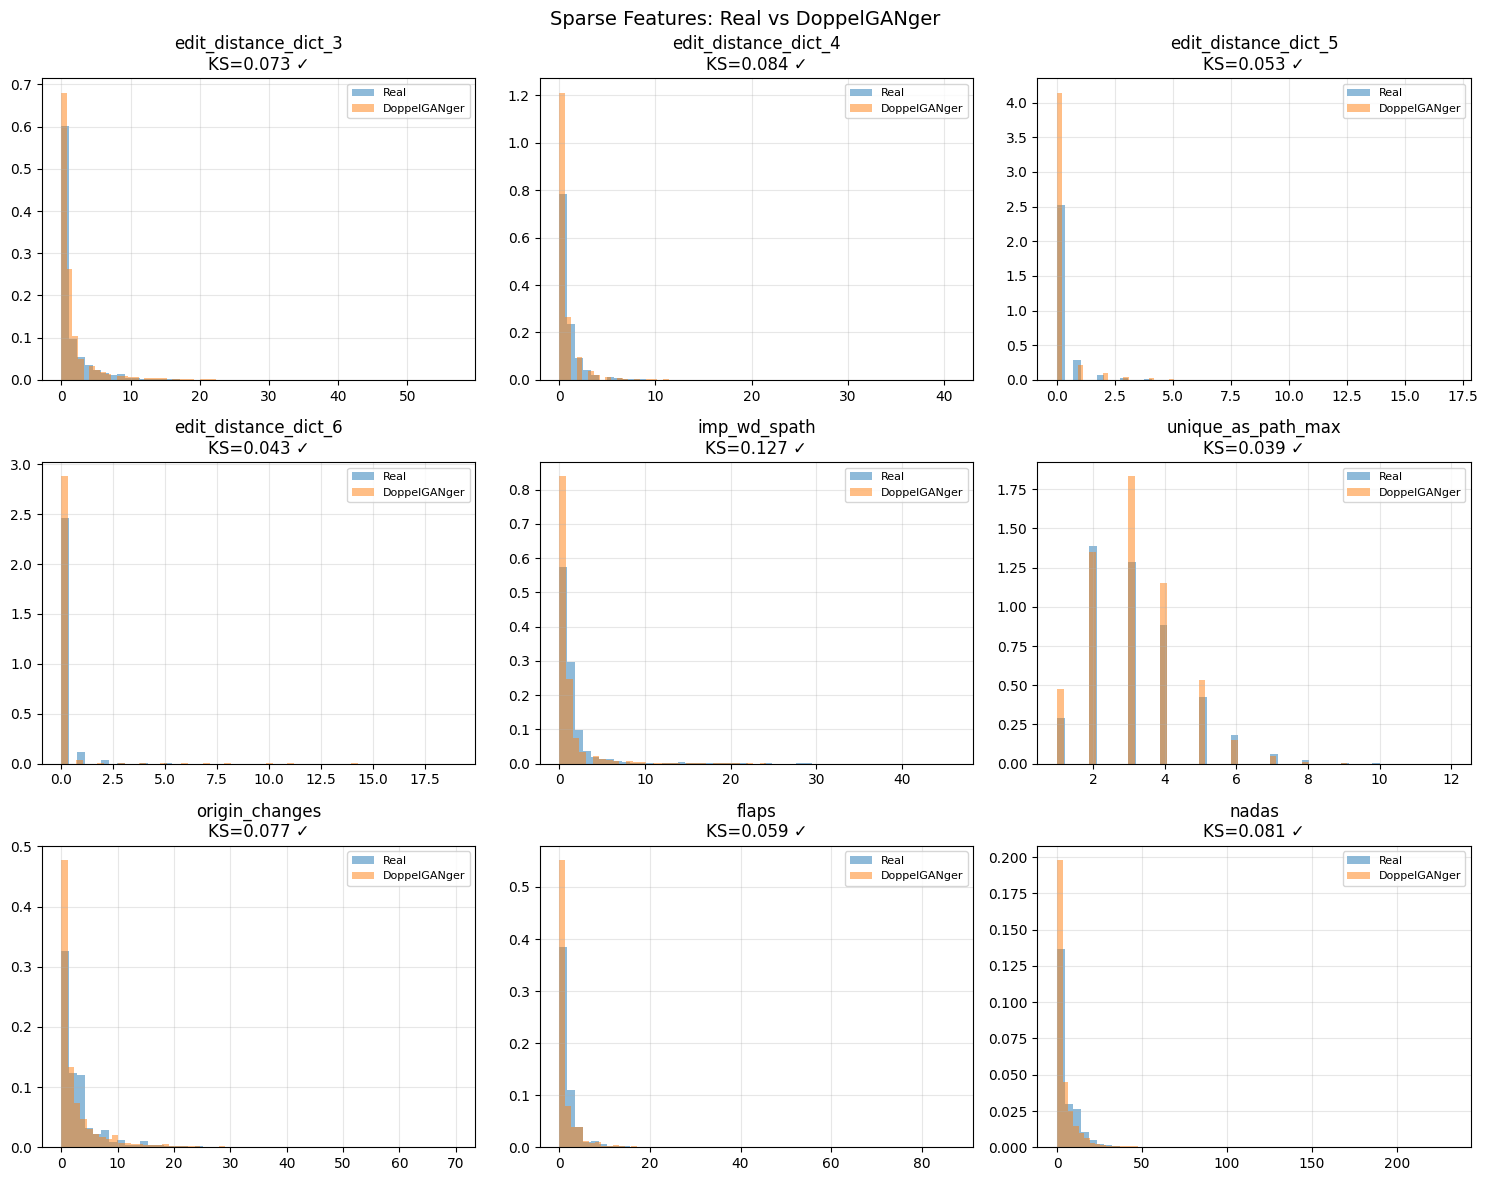

In [44]:
# Sparse feature distribution comparison (best model)
real_flat = X_test_original.reshape(-1, NUM_FEATURES)
syn_flat = synthetic_processed[best_model].reshape(-1, NUM_FEATURES)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, feat in enumerate(SPARSE_FEATURES[:9]):
    if feat in available_features:
        idx = available_features.index(feat)
        ax = axes[i//3, i%3]
        ax.hist(real_flat[:, idx], bins=50, alpha=0.5, label='Real', density=True)
        ax.hist(syn_flat[:, idx], bins=50, alpha=0.5, label=best_model, density=True)
        ks = all_metrics[best_model]['per_feature'].get(feat, {}).get('ks', 0)
        status = "✓" if ks < 0.2 else "✗"
        ax.set_title(f'{feat}\nKS={ks:.3f} {status}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle(f'Sparse Features: Real vs {best_model}', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sparse_features.png'), dpi=150)
plt.show()

## Part 13: Save Results

In [45]:
# Save synthetic data for all models
for name, syn_data in synthetic_processed.items():
    n, s, f = syn_data.shape
    rows = []
    for seq_idx in range(n):
        for t in range(s):
            row = {'sequence_id': seq_idx, 'timestep': t, 'label': 'normal'}
            for f_idx, feat in enumerate(available_features):
                row[feat] = syn_data[seq_idx, t, f_idx]
            rows.append(row)
    
    df_syn = pd.DataFrame(rows)
    for feat in INTEGER_FEATURES:
        if feat in df_syn.columns:
            df_syn[feat] = df_syn[feat].astype(int)
    
    filename = f"synthetic_{name.lower().replace('-', '_')}_improved.csv"
    df_syn.to_csv(os.path.join(OUTPUT_DIR, filename), index=False)
    print(f"Saved {filename}: {len(df_syn):,} rows")

# Copy best to main output
import shutil
best_src = os.path.join(OUTPUT_DIR, f"synthetic_{best_model.lower().replace('-', '_')}_improved.csv")
best_dst = os.path.join(OUTPUT_DIR, 'synthetic_normal_traffic_best.csv')
shutil.copy(best_src, best_dst)
print(f"\nBest model saved as: synthetic_normal_traffic_best.csv")

Saved synthetic_lstm_gan_improved.csv: 60,000 rows
Saved synthetic_timegan_improved.csv: 60,000 rows
Saved synthetic_doppelganger_improved.csv: 60,000 rows

Best model saved as: synthetic_normal_traffic_best.csv


In [46]:
# Save config and scaler
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

config = {
    'version': 'improved_complete_v1',
    'improvements': [
        'log1p transform for sparse features',
        'increased capacity (LATENT=64, LAYERS=3)',
        'histogram loss',
        'correlation loss',
        'feature-weighted MSE',
        'all three models improved'
    ],
    'sparse_features': SPARSE_FEATURES,
    'loss_weights': {'sparse': SPARSE_WEIGHT, 'hist': HIST_LOSS_WEIGHT, 'corr': CORR_LOSS_WEIGHT},
    'epochs': EPOCHS,
    'model_params': {'hidden': HIDDEN_DIM, 'latent': LATENT_DIM, 'layers': NUM_LAYERS},
    'best_model': best_model,
    'metrics': {k: {kk: vv for kk, vv in v.items() if kk not in ['per_feature', 'sparse_ks', 'poor_ks']} 
                for k, v in all_metrics.items()},
    'sparse_ks': {k: dict(v['sparse_ks']) for k, v in all_metrics.items()},
    'poor_ks_features': {k: [f[0] for f in v['poor_ks']] for k, v in all_metrics.items()},
    'timestamp': datetime.now().isoformat()
}

with open(os.path.join(OUTPUT_DIR, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2, default=str)
print("Saved config.json and scaler.pkl")

Saved config.json and scaler.pkl


In [47]:
# Final Summary
print("\n" + "="*70)
print("COMPLETE - IMPROVED VERSION (ALL 3 MODELS)")
print("="*70)
print(f"""
Improvements Applied to ALL models:
  ✓ Log1p transform for sparse features
  ✓ Increased capacity: HIDDEN={HIDDEN_DIM}, LATENT={LATENT_DIM}, LAYERS={NUM_LAYERS}
  ✓ Histogram loss (weight={HIST_LOSS_WEIGHT})
  ✓ Correlation loss (weight={CORR_LOSS_WEIGHT})
  ✓ Feature-weighted MSE (sparse_weight={SPARSE_WEIGHT})
  ✓ Extended training: {EPOCHS} epochs

Results Summary:
""")

print(f"{'Model':<15} {'KS (all)':<12} {'KS (sparse)':<12} {'Poor KS':<10} {'Overall':<10}")
print("-" * 60)
for name, m in all_metrics.items():
    poor = len(m['poor_ks'])
    best_mark = " <-- BEST" if name == best_model else ""
    print(f"{name:<15} {m['ks_mean']:<12.4f} {m['sparse_ks_mean']:<12.4f} {poor:<10} {m['overall_score']:<10.4f}{best_mark}")

print(f"\nOriginal problem features: {ORIGINAL_POOR}")
print(f"Best model poor KS: {[f[0] for f in all_metrics[best_model]['poor_ks']] if all_metrics[best_model]['poor_ks'] else 'NONE'}")
print(f"\nOutput: {OUTPUT_DIR}")


COMPLETE - IMPROVED VERSION (ALL 3 MODELS)

Improvements Applied to ALL models:
  ✓ Log1p transform for sparse features
  ✓ Increased capacity: HIDDEN=128, LATENT=64, LAYERS=3
  ✓ Histogram loss (weight=0.5)
  ✓ Correlation loss (weight=0.3)
  ✓ Feature-weighted MSE (sparse_weight=2.0)
  ✓ Extended training: 250 epochs

Results Summary:

Model           KS (all)     KS (sparse)  Poor KS    Overall   
------------------------------------------------------------
LSTM-GAN        0.1083       0.0515       3          0.0697    
TimeGAN         0.2963       0.2436       21         0.2200    
DoppelGANger    0.1007       0.0705       2          0.0677     <-- BEST

Original problem features: ['edit_distance_dict_3', 'imp_wd_spath', 'unique_as_path_max', 'origin_changes']
Best model poor KS: ['origin_0', 'origin_2']

Output: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs_improved/


In [48]:
# List output files
print("\nFiles:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
    print(f"  {f}: {size:.1f} KB")


Files:
  config.json: 8.0 KB
  model_comparison.png: 51.5 KB
  scaler.pkl: 1.5 KB
  sparse_features.png: 176.9 KB
  synthetic_doppelganger_improved.csv: 5332.1 KB
  synthetic_lstm_gan_improved.csv: 5402.2 KB
  synthetic_normal_traffic_best.csv: 5332.1 KB
  synthetic_timegan_improved.csv: 5353.3 KB
  training_curves.png: 117.5 KB
